#### Final Season Rankings

In [48]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../data/initial_data/awards_players.csv")
coaches = pd.read_csv("../data/initial_data/coaches.csv")
players_teams = pd.read_csv("../data/initial_data/players_teams.csv")
players = pd.read_csv("../data/initial_data/players.csv")
series_post = pd.read_csv("../data/initial_data/series_post.csv")
teams_post = pd.read_csv("../data/initial_data/teams_post.csv")
teams = pd.read_csv("../data/initial_data/teams.csv")

In [50]:
# ================================
# GET PLAYERS FOR TEAM
# ================================
def get_players_for_team(players_teams_df, year, team_id):
    """Return all players who played for a specific team in a given year."""
    return players_teams_df[
        (players_teams_df["year"] == year) &
        (players_teams_df["tmID"] == team_id)
    ].copy()

In [51]:
# ================================
# PLAYER GAME SCORE
# ================================
def get_player_game_score(players_teams_df, player_id, year):
    """
    Compute a player's game score for a given year.
    Returns a clean Python dictionary.
    """
    df_player = players_teams_df[
        (players_teams_df["playerID"] == player_id) &
        (players_teams_df["year"] == year)
    ].copy()

    if df_player.empty:
        return {
            "playerID": player_id,
            "year": year,
            "tmID": None,
            "Game_Score_Total": None,
            "Game_Score_Per_Game": None,
            "Game_Score_Per_Minute": None
        }

    # Base game score formula
    base_score = (
        df_player["points"]
        + 0.4 * df_player["fgMade"]
        - 0.7 * df_player["fgAttempted"]
        - 0.4 * (df_player["ftAttempted"] - df_player["ftMade"])
        + 0.7 * df_player["oRebounds"]
        + 0.3 * df_player["dRebounds"]
        + df_player["steals"]
        + 0.7 * df_player["assists"]
        + 0.7 * df_player["blocks"]
        - 0.4 * df_player["PF"]
        - df_player["turnovers"]
    )

    df_player["Game_Score_Total"] = base_score
    df_player["Game_Score_Per_Game"] = base_score / df_player["GP"].replace(0, np.nan)
    df_player["Game_Score_Per_Minute"] = base_score / df_player["minutes"].replace(0, np.nan)

    return {
        "playerID": player_id,
        "year": int(year),
        "tmID": ",".join(df_player["tmID"].unique()),
        "Game_Score_Total": float(df_player["Game_Score_Total"].sum(skipna=True)),
        "Game_Score_Per_Game": float(df_player["Game_Score_Per_Game"].mean(skipna=True)),
        "Game_Score_Per_Minute": float(df_player["Game_Score_Per_Minute"].mean(skipna=True)),
    }



In [52]:
# ================================
# TEAM WEIGHTED GAME SCORE
# ================================
def get_team_weighted_avg_score(players_teams_df, year, team_id):
    """
    Weighted average = mean player GameScorePerMinute weighted by GameScoreTotal.
    Uses prior-year stats (year-1), which is correct for prediction models.
    """
    df_team = get_players_for_team(players_teams_df, year, team_id)

    if df_team.empty:
        return {
            "tmID": team_id,
            "year": year,
            "Team_Weighted_Avg_Per_Minute": None,
            "Num_Players": 0
        }

    player_scores = []
    for player_id in df_team["playerID"].unique():
        player_scores.append(get_player_game_score(players_teams_df, player_id, year - 1))

    df_scores = pd.DataFrame(player_scores)

    total_weight = df_scores["Game_Score_Total"].sum(skipna=True)
    if not total_weight or np.isnan(total_weight):
        weighted_avg = None
    else:
        weighted_avg = (
            (df_scores["Game_Score_Per_Minute"] * df_scores["Game_Score_Total"]).sum(skipna=True)
            / total_weight
        )

    return {
        "tmID": team_id,
        "year": year,
        "Team_Weighted_Avg_Per_Minute": float(weighted_avg) if weighted_avg is not None else None,
        "Num_Players": int(len(df_scores))
    }


In [53]:
# ================================
# CONFERENCE RANKINGS
# ================================
def get_conference_rankings(players_teams_df, teams_df, year):
    """
    Predict conference rankings using team weighted scores.
    Returns (Eastern_df, Western_df).
    """
    teams_year = teams_df[teams_df["year"] == year][[
        "tmID", "confID", "name", "rank", "won", "lost"
    ]].copy()

    if teams_year.empty:
        print(f"No team data found for year {year}.")
        return pd.DataFrame(), pd.DataFrame()

    teams_year.rename(columns={"rank": "Actual_Rank"}, inplace=True)

    # Compute weighted score for each team
    team_results = [
        get_team_weighted_avg_score(players_teams_df, year, tm)
        for tm in teams_year["tmID"].unique()
    ]

    df_scores = pd.DataFrame(team_results)
    df_scores = df_scores.merge(teams_year, on="tmID", how="left")

    # Rank within each conference
    df_scores["Predicted_Rank_Conf"] = (
        df_scores.groupby("confID")["Team_Weighted_Avg_Per_Minute"]
        .rank(ascending=False, method="first")
    )

    df_scores["Rank_Diff"] = (
        df_scores["Predicted_Rank_Conf"] - df_scores["Actual_Rank"]
    )

    # Separate conferences
    east_df = df_scores[df_scores["confID"] == "EA"].sort_values("Predicted_Rank_Conf").reset_index(drop=True)
    west_df = df_scores[df_scores["confID"] == "WE"].sort_values("Predicted_Rank_Conf").reset_index(drop=True)

    return east_df, west_df

In [54]:
# ================================
# EXAMPLE
# ================================
east_rankings, west_rankings = get_conference_rankings(players_teams, teams, year=10)

print("\n🏀 EASTERN CONFERENCE")
print(east_rankings)

print("\n🏀 WESTERN CONFERENCE")
print(west_rankings)


🏀 EASTERN CONFERENCE
  tmID  year  Team_Weighted_Avg_Per_Minute  Num_Players confID  \
0  CON    10                      0.318042           14     EA   
1  DET    10                      0.301598           18     EA   
2  CHI    10                      0.291838           12     EA   
3  NYL    10                      0.288212           11     EA   
4  ATL    10                      0.281187           13     EA   
5  IND    10                      0.273435           14     EA   
6  WAS    10                      0.232280           12     EA   

                 name  Actual_Rank  won  lost  Predicted_Rank_Conf  Rank_Diff  
0     Connecticut Sun            6   16    18                  1.0       -5.0  
1       Detroit Shock            3   18    16                  2.0       -1.0  
2         Chicago Sky            5   16    18                  3.0       -2.0  
3    New York Liberty            7   13    21                  4.0       -3.0  
4       Atlanta Dream            2   18    16    

## Predicative Model PipeLine 

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# ======================================================
# HELPER FUNCTIONS
# ======================================================

def get_players_for_team(players_teams_df, year, team_id):
    return players_teams_df[
        (players_teams_df["year"] == year) &
        (players_teams_df["tmID"] == team_id)
    ].copy()


def calculate_player_score(df):
    """Apply your Game Score formula to a DataFrame of players."""
    base = (
        df["points"]
        + 0.4 * df["fgMade"]
        - 0.7 * df["fgAttempted"]
        - 0.4 * (df["ftAttempted"] - df["ftMade"])
        + 0.7 * df["oRebounds"]
        + 0.3 * df["dRebounds"]
        + df["steals"]
        + 0.7 * df["assists"]
        + 0.7 * df["blocks"]
        - 0.4 * df["PF"]
        - df["turnovers"]
    )

    df["Game_Score_Total"] = base
    df["Game_Score_Per_Minute"] = base / df["minutes"].replace(0, np.nan)
    return df


def get_team_weighted_score(players_teams_df, year, team_id):
    """Weighted avg player score using previous season."""
    df = get_players_for_team(players_teams_df, year - 1, team_id)
    if df.empty:
        return None, 0

    df = calculate_player_score(df)

    total_weight = df["Game_Score_Total"].sum(skipna=True)
    if total_weight == 0 or np.isnan(total_weight):
        return None, len(df)

    weighted_avg = (
        (df["Game_Score_Per_Minute"] * df["Game_Score_Total"]).sum()
        / total_weight
    )

    return float(weighted_avg), len(df)


def get_team_continuity(players_teams_df, year, tmID):
    """Fraction of players returning from previous year."""
    prev_players = set(players_teams_df[(players_teams_df["year"] == year-1) & (players_teams_df["tmID"] == tmID)]["playerID"])
    curr_players = set(players_teams_df[(players_teams_df["year"] == year) & (players_teams_df["tmID"] == tmID)]["playerID"])
    if not prev_players or not curr_players:
        return 0
    return len(prev_players & curr_players) / len(prev_players)


def get_coach_win_pct(coaches_df, teams_df, year, tmID):
    """Coach historical win pct before given year."""
    df = coaches_df[(coaches_df["tmID"] == tmID) & (coaches_df["year"] < year)]
    if df.empty:
        return 0
    wins, games = 0, 0
    for _, row in df.iterrows():
        team_row = teams_df[(teams_df["tmID"] == tmID) & (teams_df["year"] == row["year"])]
        if not team_row.empty:
            wins += team_row.iloc[0]["won"]
            games += team_row.iloc[0]["GP"]
    return wins / max(games, 1)


def get_coach_features(coaches_df, tmID, year):
    """Return coach experience and whether a coach changed from prev season."""
    df = coaches_df[coaches_df["tmID"] == tmID]

    this_year = df[df["year"] == year]
    prev_year = df[df["year"] == year - 1]

    if this_year.empty:
        return 0, 0

    coach_id = this_year["coachID"].iloc[0]

    # Experience = total seasons coached before this year
    experience = len(
        df.loc[(df["coachID"] == coach_id) & (df["year"] < year)]
    )

    # Coach change?
    changed = int(prev_year.empty or prev_year["coachID"].iloc[0] != coach_id)

    return experience, changed


def evaluate_spearman(df):
    return spearmanr(df["Actual_Rank"], df["Predicted_Rank"]).correlation


def top_k_accuracy(df, k=1):
    actual_top_k = set(df.sort_values("Actual_Rank").head(k)["tmID"])
    predicted_top_k = set(df.sort_values("Predicted_Rank").head(k)["tmID"])
    return len(actual_top_k & predicted_top_k) / k


def evaluate_kendall(df):
    return kendalltau(df["Actual_Rank"], df["Predicted_Rank"]).correlation


def evaluate_year_predictions(df):
    results = {}

    for conf in ["EA", "WE"]:
        conf_df = df[df["confID"] == conf].copy()

        spearman = evaluate_spearman(conf_df)
        kendall = evaluate_kendall(conf_df)
        top1 = top_k_accuracy(conf_df, k=1)
        top3 = top_k_accuracy(conf_df, k=3)
        mae = mean_absolute_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"])
        rmse = np.sqrt(mean_squared_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]))

        results[conf] = {
            "Spearman": spearman,
            "KendallTau": kendall,
            "Top1_Accuracy": top1,
            "Top3_Accuracy": top3,
            "MAE": mae,
            "RMSE": rmse,
        }

    return results



# ======================================================
# BUILD TRUE PRESEASON TRAINING DATASET (year Y label, year Y-1 features)
# ======================================================
rows = []

all_years = sorted(teams["year"].unique())

for year in all_years:
    # We cannot build preseason features for the first season
    prev_year = year - 1
    prev_teams = teams[teams["year"] == prev_year]

    for _, row in teams[teams["year"] == year].iterrows():
        tmID = row["tmID"]

        # Get previous-year roster weighted score
        wscore, num_players = get_team_weighted_score(players_teams, year, tmID)

        # Continuity = between prev_year and year
        continuity = get_team_continuity(players_teams, year, tmID)

        # Previous season team stats
        prev_team = prev_teams[prev_teams["tmID"] == tmID]
        if prev_team.empty:
            continue

        prev = prev_team.iloc[0]

        prev_winpct = prev["won"] / max(prev["GP"], 1)
        prev_pf = prev["o_pts"]
        prev_pa = prev["d_pts"]

        # Coach historical win pct *before* this year
        coach_win = get_coach_win_pct(coaches, teams, year, tmID)

        rows.append({
            "year": year,
            "tmID": tmID,
            "confID": row["confID"],
            "Actual_Rank": row["rank"],   # TARGET = rank of upcoming season

            # Features from year-1
            "WeightedScore": wscore,
            "Continuity": continuity,
            "PrevWinPct": prev_winpct,
            "PrevPointsFor": prev_pf,
            "PrevPointsAgainst": prev_pa,
            "CoachWinPct": coach_win
        })

dataset = pd.DataFrame(rows).dropna()
dataset.to_csv("preseason_training_data.csv", index=False)

print(dataset.head())



# ======================================================
# PREPARE ML INPUTS
# ======================================================
feature_cols = [
    "WeightedScore",
    "Continuity",
    "PrevWinPct", 
    "PrevPointsFor", 
    "PrevPointsAgainst", 
    "CoachWinPct"
]

X = dataset[feature_cols]
y = dataset["Actual_Rank"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


# ======================================================
# TRAIN RANDOM FOREST MODEL
# ======================================================
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,             # slightly deeper to recover Spearman
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    bootstrap=True,
    random_state=42
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("Model Performance:")
print("MAE:", mae)
print("RMSE:", rmse)


# ======================================================
# FEATURE IMPORTANCE
# ======================================================
feat_imp = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

feat_imp.to_csv("feature_importances.csv", index=False)
print("Saved feature_importances.csv")
print(feat_imp)


# ======================================================
# PREDICT RANKINGS FOR A SPECIFIC YEAR
# ======================================================
def preseason_predict_conference_rankings(year, players_teams_df, teams_df, coaches_df, model, feature_cols):
    """
    Predict preseason conference rankings for a given season
    using only historical data (previous seasons).
    
    Returns:
        east_df, west_df: DataFrames with tmID, predicted rank, and features
    """
    rows = []

    # Get all teams for the target year
    teams_this_year = teams_df[teams_df["year"] == year]
    if teams_this_year.empty:
        raise ValueError(f"No team data found for year {year}.")

    for _, row in teams_this_year.iterrows():
        tmID = row["tmID"]

        # Features from historical data
        wscore, num_players = get_team_weighted_score(players_teams_df, year, tmID)
        continuity = get_team_continuity(players_teams_df, year, tmID)
        
        prev_team = teams_df[(teams_df["tmID"] == tmID) & (teams_df["year"] == year - 1)]
        if prev_team.empty:
            prev_winpct = 0
            prev_pts_for = 0
            prev_pts_against = 0
        else:
            prev = prev_team.iloc[0]
            prev_winpct = prev["won"] / max(prev["GP"], 1)
            prev_pts_for = prev["o_pts"]
            prev_pts_against = prev["d_pts"]

        coach_win = get_coach_win_pct(coaches_df, teams_df, year, tmID)

        rows.append({
            "tmID": tmID,
            "confID": row["confID"],
            "WeightedScore": wscore,
            "Continuity": continuity,
            "PrevWinPct": prev_winpct,
            "PrevPointsFor": prev_pts_for,
            "PrevPointsAgainst": prev_pts_against,
            "CoachWinPct": coach_win
        })

    pred_df = pd.DataFrame(rows).dropna()
    # Predict ranks
    pred_df["Predicted_Rank"] = model.predict(pred_df[feature_cols])
    pred_df = pred_df.sort_values("Predicted_Rank")

    east_df = pred_df[pred_df["confID"] == "EA"].copy()
    west_df = pred_df[pred_df["confID"] == "WE"].copy()

    return east_df, west_df


# Example usage
east, west = preseason_predict_conference_rankings(
    year=8,  # next season
    players_teams_df=players_teams,
    teams_df=teams,
    coaches_df=coaches,
    model=model,
    feature_cols=feature_cols
)

print("\nPredicted EAST:")
print(east)

print("\nPredicted WEST:")
print(west)


   year tmID confID  Actual_Rank  WeightedScore  Continuity  PrevWinPct  \
0     2  CHA     EA            4       0.265591    0.384615     0.25000   
1     2  CLE     EA            1       0.242527    0.846154     0.53125   
2     2  DET     EA            7       0.250346    0.538462     0.43750   
3     2  HOU     WE            4       0.355958    0.583333     0.84375   
4     2  IND     EA            6       0.260149    0.466667     0.28125   

   PrevPointsFor  PrevPointsAgainst  CoachWinPct  
0           2186               2429      0.25000  
1           2185               2122      0.53125  
2           2331               2426      0.43750  
3           2475               2066      0.84375  
4           2213               2290      0.28125  
Model Performance:
MAE: 1.7709166263409797
RMSE: 1.9316485166724686
Saved feature_importances.csv
             Feature  Importance
5        CoachWinPct    0.206670
2         PrevWinPct    0.192006
3      PrevPointsFor    0.185508
4  PrevPoints

## Evaluating the Model


=== Average Metrics Across All Years ===
  confID  Year  Spearman  KendallTau       MAE      RMSE  Top1_Accuracy  \
0     EA   6.0  0.791534    0.681481  1.159207  1.341353       0.666667   
1     WE   6.0  0.820370    0.705291  1.178690  1.425263       0.555556   

   Top3_Accuracy  
0       0.777778  
1       0.814815  

 OVERFITTING CHECK: Train vs Test
Train MAE: 1.038
Test  MAE: 1.771
Gap      : 0.733
⚠️ Mild Overfitting.

 GROUP K-FOLD CROSS-VALIDATION (YEAR-BY-YEAR)
Fold 1: Train MAE = 1.000, Test MAE = 1.956
Fold 2: Train MAE = 1.016, Test MAE = 1.856
Fold 3: Train MAE = 1.056, Test MAE = 1.542
Fold 4: Train MAE = 1.072, Test MAE = 1.516
Fold 5: Train MAE = 1.073, Test MAE = 1.432

 CROSS-VALIDATION SUMMARY
Avg Train MAE: 1.043
Avg Test  MAE: 1.660
Gap         : 0.617


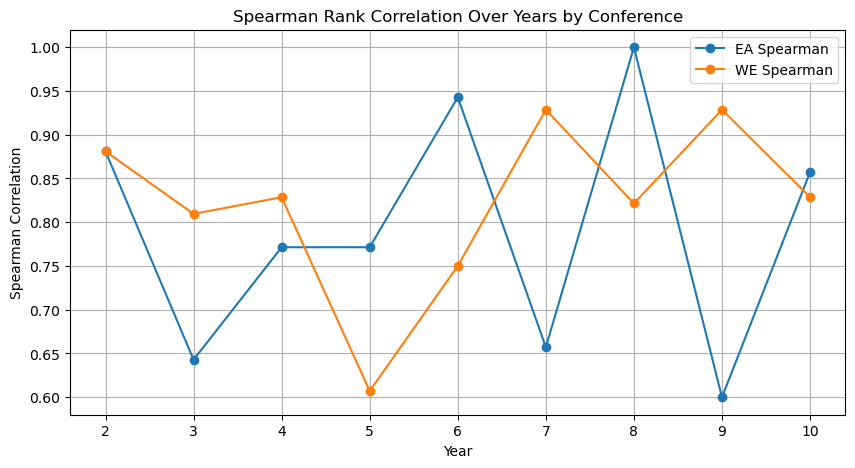

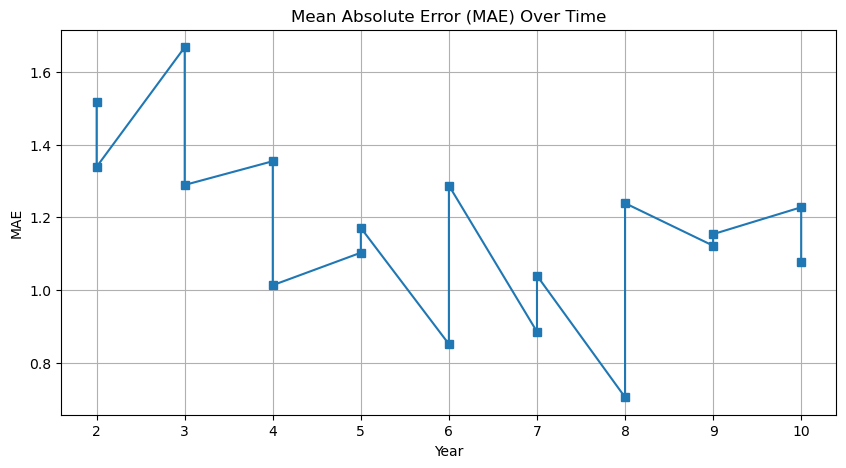

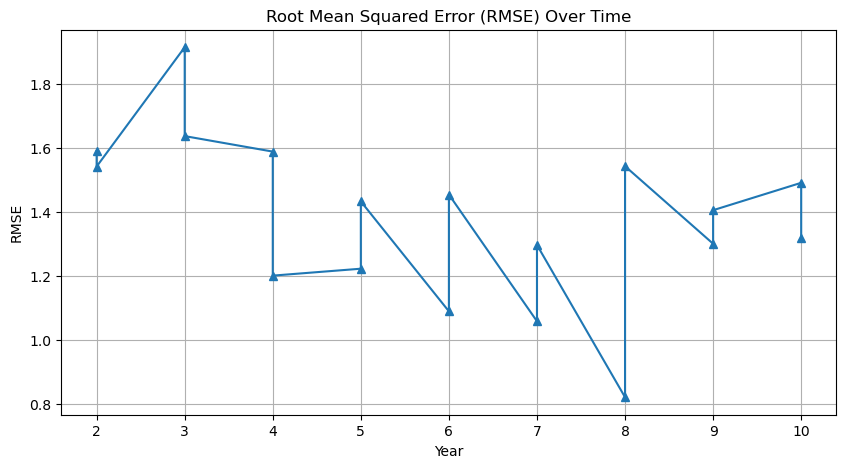

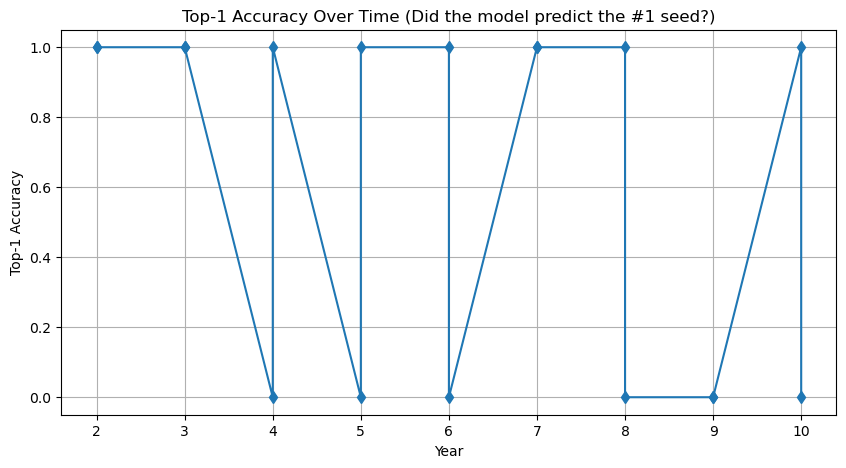

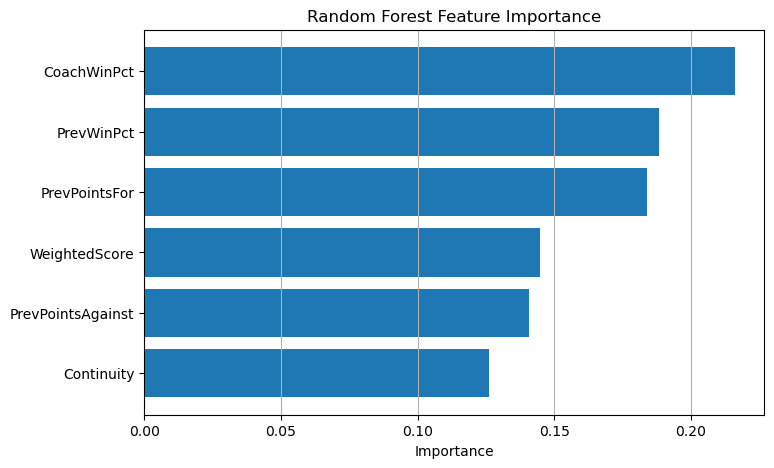

In [56]:
# ======================================================
# COMPREHENSIVE MODEL EVALUATION FUNCTION
# ======================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, kendalltau
from sklearn.model_selection import GroupKFold

def top_k_accuracy(df, k=1):
    """Compute top-k accuracy for rankings."""
    actual_top_k = set(df.sort_values("Actual_Rank").head(k)["tmID"])
    predicted_top_k = set(df.sort_values("Predicted_Rank").head(k)["tmID"])
    return len(actual_top_k & predicted_top_k) / k

def evaluate_comprehensive(dataset, feature_cols, model, save_path_prefix="evaluation"):
    results_all = []

    # --------------------------
    # Predict per year
    # --------------------------
    for year in sorted(dataset["year"].unique()):
        df_year = dataset[dataset["year"] == year].copy()
        if df_year.empty:
            continue
        df_year["Predicted_Rank"] = model.predict(df_year[feature_cols])

        for conf in ["EA", "WE"]:
            conf_df = df_year[df_year["confID"] == conf].copy()
            if conf_df.empty:
                continue

            spearman = spearmanr(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
            kendall = kendalltau(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]).correlation
            mae = mean_absolute_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"])
            rmse = np.sqrt(mean_squared_error(conf_df["Actual_Rank"], conf_df["Predicted_Rank"]))
            top1 = top_k_accuracy(conf_df, k=1)
            top3 = top_k_accuracy(conf_df, k=3)

            results_all.append({
                "Year": year,
                "confID": conf,
                "Spearman": spearman,
                "KendallTau": kendall,
                "MAE": mae,
                "RMSE": rmse,
                "Top1_Accuracy": top1,
                "Top3_Accuracy": top3
            })

    # --------------------------
    # Save detailed results
    # --------------------------
    results_df = pd.DataFrame(results_all)
    results_df.to_csv(f"{save_path_prefix}_by_year.csv", index=False)

    # Average metrics per conference
    avg_df = results_df.groupby("confID").mean(numeric_only=True).reset_index()
    avg_df.to_csv(f"{save_path_prefix}_averages.csv", index=False)
    
    print("\n=== Average Metrics Across All Years ===")
    print(avg_df)

    # --------------------------
    # Overfitting Check: Train vs Test
    # --------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        dataset[feature_cols], dataset["Actual_Rank"], test_size=0.2, shuffle=True, random_state=42
    )
    train_preds = model.predict(X_train)
    test_preds  = model.predict(X_test)
    train_mae = mean_absolute_error(y_train, train_preds)
    test_mae  = mean_absolute_error(y_test, test_preds)
    print("\n===============================")
    print(" OVERFITTING CHECK: Train vs Test")
    print("===============================")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test  MAE: {test_mae:.3f}")
    gap = test_mae - train_mae
    print(f"Gap      : {gap:.3f}")
    if gap > 1.0:
        print("⚠️ Strong Overfitting Detected!")
    elif gap > 0.3:
        print("⚠️ Mild Overfitting.")
    else:
        print("✅ No significant overfitting.")

    # --------------------------
    # GroupKFold CV by Year
    # --------------------------
    gkf = GroupKFold(n_splits=5)
    cv_train_mae, cv_test_mae = [], []
    print("\n===============================")
    print(" GROUP K-FOLD CROSS-VALIDATION (YEAR-BY-YEAR)")
    print("===============================")
    X_full = dataset[feature_cols]
    y_full = dataset["Actual_Rank"]
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full, groups=dataset["year"])):
        X_tr, X_te = X_full.iloc[train_idx], X_full.iloc[test_idx]
        y_tr, y_te = y_full.iloc[train_idx], y_full.iloc[test_idx]

        model.fit(X_tr, y_tr)
        preds_tr = model.predict(X_tr)
        preds_te = model.predict(X_te)
        mae_tr = mean_absolute_error(y_tr, preds_tr)
        mae_te = mean_absolute_error(y_te, preds_te)
        cv_train_mae.append(mae_tr)
        cv_test_mae.append(mae_te)
        print(f"Fold {fold+1}: Train MAE = {mae_tr:.3f}, Test MAE = {mae_te:.3f}")

    print("\n===============================")
    print(" CROSS-VALIDATION SUMMARY")
    print("===============================")
    print(f"Avg Train MAE: {np.mean(cv_train_mae):.3f}")
    print(f"Avg Test  MAE: {np.mean(cv_test_mae):.3f}")
    print(f"Gap         : {np.mean(cv_test_mae) - np.mean(cv_train_mae):.3f}")

    # --------------------------
    # Plot Spearman over years
    # --------------------------
    plt.figure(figsize=(10,5))
    for conf in ["EA", "WE"]:
        conf_df = results_df[results_df["confID"] == conf]
        plt.plot(conf_df["Year"], conf_df["Spearman"], marker="o", label=f"{conf} Spearman")
    plt.title("Spearman Rank Correlation Over Years by Conference")
    plt.xlabel("Year")
    plt.ylabel("Spearman Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()

    # MAE over time
    plt.figure(figsize=(10,5))
    plt.plot(results_df["Year"], results_df["MAE"], marker="s")
    plt.title("Mean Absolute Error (MAE) Over Time")
    plt.xlabel("Year")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.show()

    # RMSE over time
    plt.figure(figsize=(10,5))
    plt.plot(results_df["Year"], results_df["RMSE"], marker="^")
    plt.title("Root Mean Squared Error (RMSE) Over Time")
    plt.xlabel("Year")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

    # Top-1 Accuracy over time
    plt.figure(figsize=(10,5))
    plt.plot(results_df["Year"], results_df["Top1_Accuracy"], marker="d")
    plt.title("Top-1 Accuracy Over Time (Did the model predict the #1 seed?)")
    plt.xlabel("Year")
    plt.ylabel("Top-1 Accuracy")
    plt.grid(True)
    plt.show()

    # Feature Importance
    feat_imp = pd.DataFrame({
        "Feature": feature_cols,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)

    plt.figure(figsize=(8,5))
    plt.barh(feat_imp["Feature"], feat_imp["Importance"])
    plt.title("Random Forest Feature Importance")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.grid(axis="x")
    plt.show()

    return results_df, avg_df, feat_imp

results_df, avg_df, feat_imp = evaluate_comprehensive(dataset, feature_cols, model)